<a href="https://colab.research.google.com/github/hnioua/OCR-Text-Recognition-in-Challenging-Conditions/blob/main/NooteBook_OCR_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction du texte des images à faible résolution (OCR)  


---

**Réalisé par :**  
- LAALIJI Zakariae  
- HNIOUA Abdessamad  
*Étudiants en Master IAII, Département Informatique*  
*Faculté des Sciences et Techniques, Université Cadi Ayyad, Marrakech, Maroc*

**Encadré par :**  
- Dr. Madame Laila Amir   
*Université Cadi Ayyad*  
*Faculté des Sciences et Techniques, Marrakech*  
*Master IAII — Département Informatique*


# Installation de bibliothèque demander et importation des bibliothèques

In [1]:
!apt-get install unrar
!pip install keras-tuner
!pip install rarfile
!pip install imbalanced-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

In [4]:
# Librairies standards
import os  # Pour la gestion des fichiers et répertoires
import random  # Pour les opérations aléatoires (ex. sélection aléatoire)
from collections import Counter, defaultdict  # Structures utiles pour les statistiques et les regroupements

# Gestion de données et visualisation
import numpy as np  # Pour les opérations numériques efficaces sur tableaux
import pandas as pd  # Pour la manipulation des données tabulaires (DataFrame)
import matplotlib.pyplot as plt  # Pour la visualisation de données
import seaborn as sns  # Pour les visualisations statistiques plus esthétiques

# Traitement d’images
import cv2  # OpenCV pour la lecture, l’écriture et le traitement d’images
from PIL import Image  # Bibliothèque PIL pour le traitement d’images (alternative ou complément à OpenCV)

# Machine Learning et prétraitement
from sklearn.model_selection import train_test_split  # Pour diviser le jeu de données en ensembles d'entraînement/test
from sklearn.metrics import classification_report  # Pour générer un rapport d’évaluation du modèle
from sklearn.preprocessing import LabelEncoder  # Pour convertir des étiquettes en valeurs numériques

# Gestion du déséquilibre de classes
from imblearn.over_sampling import SMOTE  # Technique d’oversampling pour équilibrer les classes minoritaires

# TensorFlow et Keras (modélisation, entraînement, callbacks)
import tensorflow as tf  # Bibliothèque principale de deep learning
from tensorflow.keras.utils import to_categorical  # Conversion des labels en one-hot encoding
from tensorflow.keras.models import Sequential  # Modèle séquentiel simple
from tensorflow.keras.layers import (  # Couches de base pour créer un réseau de neurones convolutionnel
    Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Flatten,
    GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam  # Optimiseur Adam
from tensorflow.keras.callbacks import (  # Callbacks utiles pour contrôler l'entraînement
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.applications import (  # Réseaux de neurones pré-entraînés
    EfficientNetB7, MobileNetV2, VGG19, DenseNet121
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation de données

# pour extraire des fichiers .rar si nécessaire
import rarfile  # Pour manipuler des fichiers compressés au format .rar


# 1) Préparation du dataset

In [5]:
# Chemin vers le fichier RAR
rar_path = "Data.rar"  # Assure-toi que ce chemin est correct

# Répertoire de destination
extract_dir = "data_images"

# Extraire le contenu
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_dir)

In [6]:
with rarfile.RarFile(rar_path) as rf:
    for f in rf.infolist():
        try:
            rf.extract(f, extract_dir)
        except rarfile.BadRarFile as e:
            print(f"Erreur d'extraction pour {f.filename}: {e}")

### Augmentation de Données pour OCR sur Images à Faible Résolution

Ce chapitre présente les différentes techniques d’augmentation de données appliquées afin de simuler les défauts courants dans les images à faible résolution. L’objectif est d’améliorer la robustesse du modèle OCR face à des images bruitées, floues ou dégradées.


Pour améliorer un système OCR appliqué à des images de **faible qualité**, on applique des **transformations artificielles** sur les images d'entraînement. Cela renforce la **robustesse du modèle** face aux imperfections du monde réel.

### Transformations utilisées

| Transformation               | Défaut simulé                       | Objectif pour l'OCR                        |
|-----------------------------|-------------------------------------|-------------------------------------------|
| Bruit gaussien              | Bruit du capteur, compression       | Tolérance au bruit                         |
| Sel et poivre               | Pixels morts, artefacts             | Reconnaissance malgré des défauts locaux   |
| Trous noirs                 | Détérioration, encre                | Reconnaître des lettres incomplètes        |
| Variation de luminosité     | Éclairage inégal                    | Adaptabilité à différentes expositions     |
| Éblouissement               | Reflets                             | Ignorer les zones surexposées              |
| Compression JPEG            | Basse qualité                       | Lire les textes flous                      |
| Redimensionnement flou      | Flou optique                        | Reconnaître des caractères mal nets        |
| Morphologie (érosion, etc.) | Déformation du texte                | Résister aux variations structurelles      |
| Filtres de flou             | Mouvements, mise au point           | Robustesse au flou léger                   |

Ces techniques d’**augmentation de données** simulent des dégradations réalistes. Elles permettent d’**entraîner un modèle OCR plus robuste**, capable de lire correctement du texte même dans des **conditions dégradées ou réelles complexes**.


In [7]:
    # ---------------------
    # Fonctions de bruit
    # ---------------------

    def add_gaussian_noise(image, mean=0, sigma=20):
        # Ajoute un bruit gaussien à l'image
        gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
        noisy = cv2.add(image, gauss)
        return noisy

    def add_salt_pepper_noise(image, amount=0.02):
        # Ajoute du bruit "sel et poivre"
        noisy = image.copy()
        num_pixels = int(amount * image.size)
        y_coords = np.random.randint(0, image.shape[0], num_pixels)
        x_coords = np.random.randint(0, image.shape[1], num_pixels)
        is_salt = np.random.choice([True, False], num_pixels)
        noisy[y_coords[is_salt], x_coords[is_salt]] = 255
        noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0
        return noisy

    def add_holes(image, count=50, size=2):
        # Ajoute des trous noirs dans l'image
        img = image.copy()
        h, w = img.shape
        for _ in range(count):
            y = np.random.randint(0, h - size)
            x = np.random.randint(0, w - size)
            img[y:y+size, x:x+size] = 0
        return img

    def adjust_brightness(image, factor=1.2):
        # Ajuste la luminosité de l'image
        return np.clip(image * factor, 0, 255).astype(np.uint8)

    def add_glare(image, center=None, radius=30, intensity=150):
        # Ajoute un effet d'éblouissement circulaire
        glare = np.zeros_like(image)
        if center is None:
            center = (image.shape[1]//2, image.shape[0]//2)
        cv2.circle(glare, center, radius, (intensity,), -1)
        glare = cv2.GaussianBlur(glare, (0, 0), radius/2)
        return np.clip(image + glare, 0, 255).astype(np.uint8)

    def reduce_quality(image, quality=30):
        # Réduit la qualité JPEG de l'image
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', image, encode_param)
        decimg = cv2.imdecode(encimg, 0)
        return decimg

    def downscale_then_upscale(image, scale=0.5):
        # Réduit et réagrandit l'image pour flouter légèrement
        h, w = image.shape
        small = cv2.resize(image, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
        return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

    # ---------------------
    # Fonctions morphologiques
    # ---------------------

    def apply_morphology(image, operation='erode', kernel_size=3):
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        if operation == 'erode':
            return cv2.erode(image, kernel, iterations=1)
        elif operation == 'dilate':
            return cv2.dilate(image, kernel, iterations=1)
        elif operation == 'open':
            return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif operation == 'close':
            return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        return image

In [8]:
# Charger une image en niveaux de gris depuis un chemin donné
img_path = 'data_images/data/E/44366.png'  # À adapter selon votre image

# Crée un répertoire de sortie s'il n'existe pas
os.makedirs("output", exist_ok=True)

# Tente de charger l'image
print(f"Tentative de chargement de l'image : {img_path}")
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Vérifie si l'image a été chargée avec succès
if img is None:
    print(f"Erreur : impossible de charger l'image depuis le chemin : {img_path}")
    print("Veuillez vérifier le chemin du fichier et vous assurer que l'image existe et n'est pas corrompue.")
else:
    print(f"Image chargée avec succès. Dimensions : {img.shape}")


Tentative de chargement de l'image : data_images/data/E/44366.png
Image chargée avec succès. Dimensions : (36, 27)


In [9]:
    print("Application des différentes transformations d'image...")
     # ---------------------
    # Appliquer toutes les transformations
    # ---------------------
    transformations = {
        "original": img,
        "gaussian_noise": add_gaussian_noise(img, sigma=10),
        "salt_pepper": add_salt_pepper_noise(img, amount=0.005),
        "holes": add_holes(img, count=10, size=2),
        "bright": adjust_brightness(img, 1.5),
        "dark": adjust_brightness(img, 0.5),
        "glare": add_glare(img, radius=20, intensity=80),
        "jpeg_quality": reduce_quality(img, quality=60),
        "downscale_upscale": downscale_then_upscale(img, scale=0.8),
        "eroded": apply_morphology(img, 'erode'),
        "dilated": apply_morphology(img, 'dilate'),
        "opened": apply_morphology(img, 'open'),
        "closed": apply_morphology(img, 'close'),
        "blur_mean": cv2.blur(img, (5, 5)),
        "blur_gaussian": cv2.GaussianBlur(img, (5, 5), 0),
        "blur_median": cv2.medianBlur(img, 5),
    }

    # Sauvegarde des images transformées
    for name, transformed in transformations.items():
        out_path = f"output/{name}.png"
        cv2.imwrite(out_path, transformed)
        print(f"Image '{name}' enregistrée dans {out_path}")

Application des différentes transformations d'image...
Image 'original' enregistrée dans output/original.png
Image 'gaussian_noise' enregistrée dans output/gaussian_noise.png
Image 'salt_pepper' enregistrée dans output/salt_pepper.png
Image 'holes' enregistrée dans output/holes.png
Image 'bright' enregistrée dans output/bright.png
Image 'dark' enregistrée dans output/dark.png
Image 'glare' enregistrée dans output/glare.png
Image 'jpeg_quality' enregistrée dans output/jpeg_quality.png
Image 'downscale_upscale' enregistrée dans output/downscale_upscale.png
Image 'eroded' enregistrée dans output/eroded.png
Image 'dilated' enregistrée dans output/dilated.png
Image 'opened' enregistrée dans output/opened.png
Image 'closed' enregistrée dans output/closed.png
Image 'blur_mean' enregistrée dans output/blur_mean.png
Image 'blur_gaussian' enregistrée dans output/blur_gaussian.png
Image 'blur_median' enregistrée dans output/blur_median.png


Affichage des images transformées :


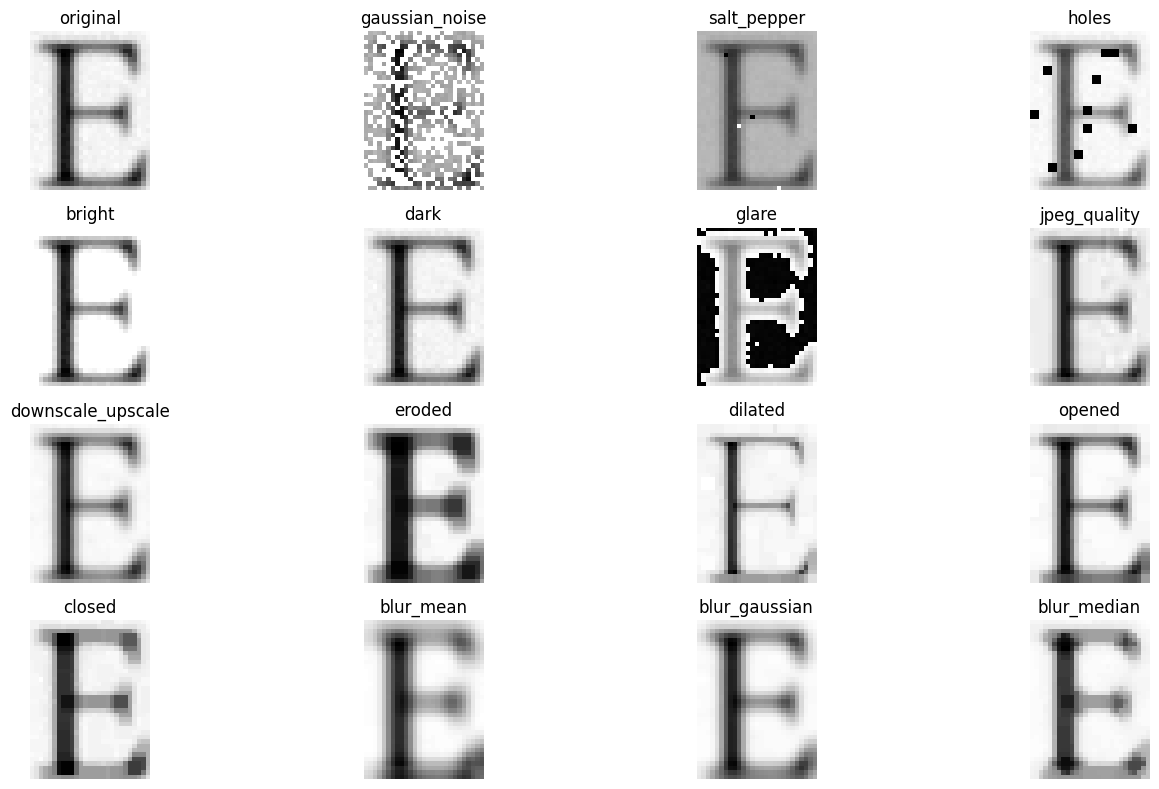

In [ ]:
   # Affiche toutes les images transformées dans une grille matplotlib
print("Affichage des images transformées :")
plt.figure(figsize=(15, 8))
for i, (name, transformed) in enumerate(transformations.items()):
    plt.subplot(4, 4, i+1)
    plt.imshow(transformed, cmap='gray')
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

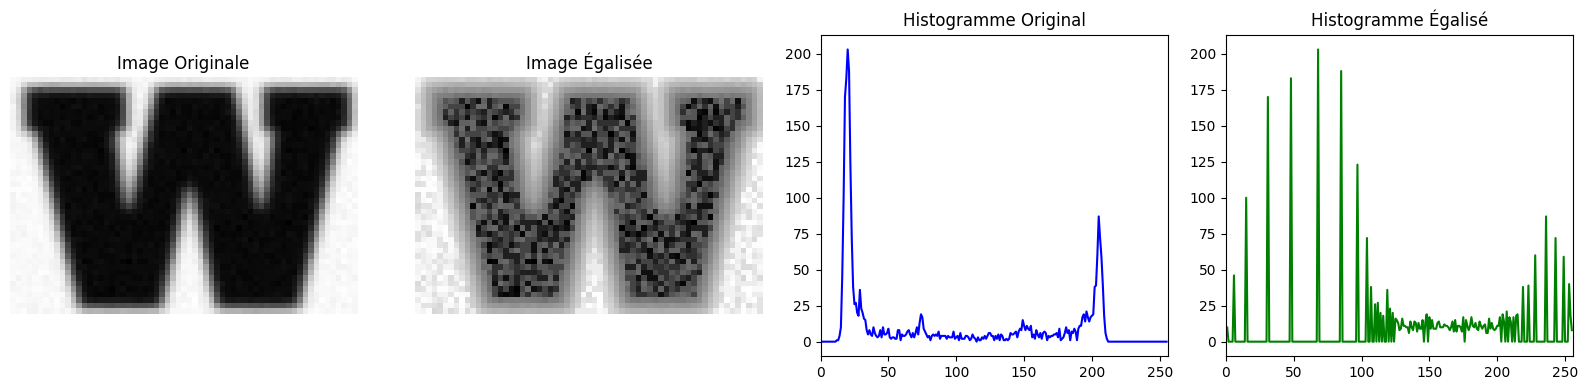

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
img_path = "data_images/data/W/41792.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Appliquer l'égalisation d'histogramme
equalized = cv2.equalizeHist(img)

# Calculer les histogrammes
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_equalized = cv2.calcHist([equalized], [0], None, [256], [0, 256])

# Affichage
plt.figure(figsize=(16, 4))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

# Image égalisée
plt.subplot(1, 4, 2)
plt.imshow(equalized, cmap='gray')
plt.title("Image Égalisée")
plt.axis('off')

# Histogramme original
plt.subplot(1, 4, 3)
plt.plot(hist_original, color='blue')
plt.title("Histogramme Original")
plt.xlim([0, 256])

# Histogramme égalisé
plt.subplot(1, 4, 4)
plt.plot(hist_equalized, color='green')
plt.title("Histogramme Égalisé")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


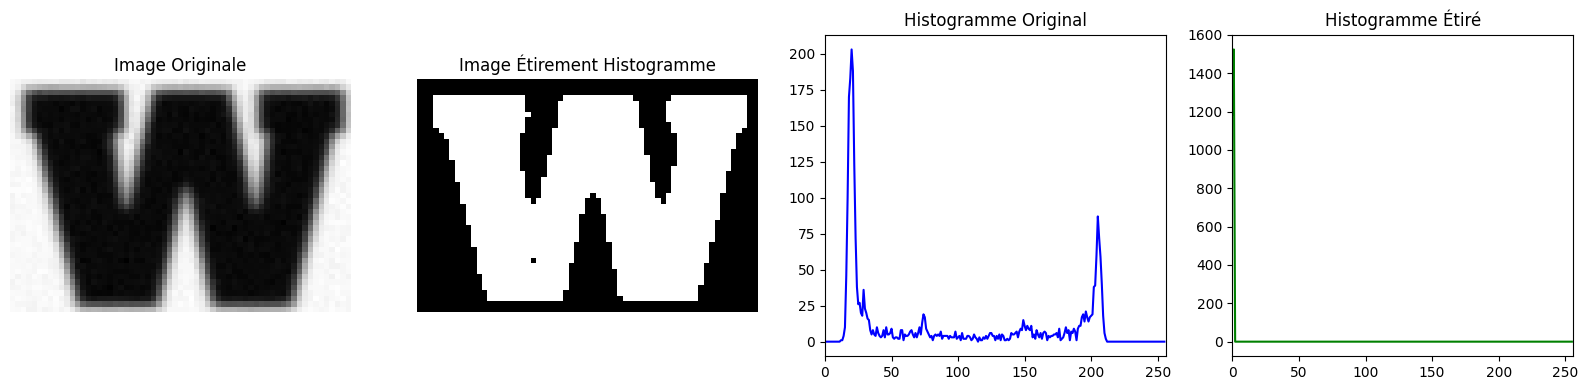

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image en niveaux de gris
img_path = "data_images/data/W/41792.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Étirement d'histogramme
min_val = np.min(img)
max_val = np.max(img)
stretched = ((img - min_val) * 255 / (max_val - min_val)).astype(np.uint8)

# Calcul des histogrammes
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_stretched = cv2.calcHist([stretched], [0], None, [256], [0, 256])

# Affichage
plt.figure(figsize=(16, 4))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Image Originale")
plt.axis('off')

# Image étirée
plt.subplot(1, 4, 2)
plt.imshow(stretched, cmap='gray')
plt.title("Image Étirement Histogramme")
plt.axis('off')

# Histogramme original
plt.subplot(1, 4, 3)
plt.plot(hist_original, color='blue')
plt.title("Histogramme Original")
plt.xlim([0, 256])

# Histogramme étiré
plt.subplot(1, 4, 4)
plt.plot(hist_stretched, color='green')
plt.title("Histogramme Étiré")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


###Création d'un DataFrame des images et de leurs étiquettes

Parcourt les dossiers d’images classés par étiquette (lettres/chiffres) et construit un DataFrame contenant le chemin de chaque image ainsi que son label associé.


In [ ]:
# Dossier racine des images extraites
base_dir = "data_images/data"

# Liste pour stocker les données
data = []

# Parcours tous les sous-dossiers (A, B, C, ..., 0, 1, 2, ...)
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        # Parcours toutes les images dans ce dossier
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                data.append({'image': image_path, 'label': folder_name})

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage des premières lignes
df.head()

,image,label
0,data_images/data/E/44366.png,E
1,data_images/data/E/41738.png,E
2,data_images/data/E/43754.png,E
3,data_images/data/E/42062.png,E
4,data_images/data/E/43718.png,E


## Fonctions de transformation

In [ ]:
# ---------------------
# Fonctions de transformation
# ---------------------
def add_gaussian_noise(image, mean=0, sigma=20):
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return cv2.add(image, gauss)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = image.copy()
    num_pixels = int(amount * image.size)
    y_coords = np.random.randint(0, image.shape[0], num_pixels)
    x_coords = np.random.randint(0, image.shape[1], num_pixels)
    is_salt = np.random.choice([True, False], num_pixels)
    noisy[y_coords[is_salt], x_coords[is_salt]] = 255
    noisy[y_coords[~is_salt], x_coords[~is_salt]] = 0
    return noisy

def add_holes(image, count=50, size=2):
    img = image.copy()
    h, w = img.shape
    for _ in range(count):
        y = np.random.randint(0, h - size)
        x = np.random.randint(0, w - size)
        img[y:y+size, x:x+size] = 0
    return img

def adjust_brightness(image, factor=1.2):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def add_glare(image, center=None, radius=30, intensity=150):
    glare = np.zeros_like(image)
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.circle(glare, center, radius, (intensity,), -1)
    glare = cv2.GaussianBlur(glare, (0, 0), radius / 2)
    return np.clip(image + glare, 0, 255).astype(np.uint8)

def reduce_quality(image, quality=30):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, 0)

def downscale_then_upscale(image, scale=0.5):
    h, w = image.shape
    small = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
    return cv2.resize(small, (w, h), interpolation=cv2.INTER_LINEAR)

def apply_morphology(image, operation='erode', kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    if operation == 'erode':
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'dilate':
        return cv2.dilate(image, kernel, iterations=1)
    elif operation == 'open':
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image

# ---------------------
# Dataset
# ---------------------
base_dir = "data_images/data"
transformations = {
    "gaussian": lambda img: add_gaussian_noise(img, sigma=10),
    "saltpepper": lambda img: add_salt_pepper_noise(img, amount=0.005),
    "holes": lambda img: add_holes(img, count=10, size=2),
    "bright": lambda img: adjust_brightness(img, 1.5),
    "dark": lambda img: adjust_brightness(img, 0.5),
    "glare": lambda img: add_glare(img, radius=20, intensity=80),
    "jpeg": lambda img: reduce_quality(img, quality=60),
    "resize": lambda img: downscale_then_upscale(img, scale=0.8),
    "erode": lambda img: apply_morphology(img, 'erode'),
    "dilate": lambda img: apply_morphology(img, 'dilate'),
    "open": lambda img: apply_morphology(img, 'open'),
    "close": lambda img: apply_morphology(img, 'close'),
    "blur_mean": lambda img: cv2.blur(img, (5, 5)),
    "blur_gaussian": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "blur_median": lambda img: cv2.medianBlur(img, 5),
}

count = 0

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Sauvegarder les transformations dans le même dossier
            name_base, ext = os.path.splitext(filename)
            for suffix, func in transformations.items():
                transformed = func(img)
                new_filename = f"{name_base}_{suffix}{ext}"
                cv2.imwrite(os.path.join(folder_path, new_filename), transformed)
                count += 1

print(f"Terminé : {count} images transformées et sauvegardées.")


Terminé : 48615 images transformées et sauvegardées.


In [ ]:
# Dictionnaire pour stocker le comptage par label
label_counts = defaultdict(int)

# Extensions d'images à considérer
valid_exts = ('.png', '.jpg', '.jpeg')

# Parcours des dossiers pour compter les images
for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue

    # Compter les fichiers image dans ce dossier
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

In [ ]:
# Assume base_dir is defined as in your code
base_dir = "data_images/data"

# Assume label_counts is populated as in your code
label_counts = defaultdict(int)
valid_exts = ('.png', '.jpg', '.jpeg')

for label_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label_folder)
    if not os.path.isdir(folder_path):
        continue
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_exts)]
    label_counts[label_folder] = len(image_files)

# Convert the defaultdict to a pandas Series
label_series = pd.Series(label_counts)

# Sort the series by index (label) for consistent plotting
label_series = label_series.sort_index()

###  Distribution des labels et équilibrage des données

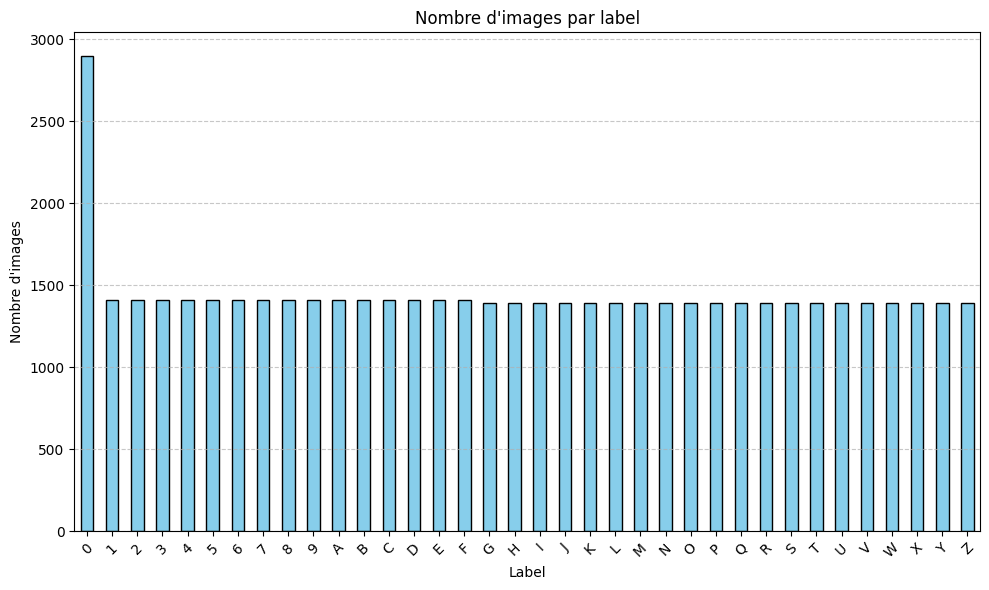

In [ ]:
# Graphe en barres
plt.figure(figsize=(10, 6))
label_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'images par label")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Le graphique montre un déséquilibre clair : la classe **'0'** contient beaucoup plus d'images (2900) que les autres (1400). Ce déséquilibre peut fausser l'entraînement du modèle.

Pour corriger cela, on peut utiliser :

- **Oversampling** : augmenter artificiellement les données des classes minoritaires (ex. : duplication, SMOTE).
- **Undersampling** : réduire les données de la classe majoritaire.

 **But** : équilibrer les classes pour améliorer la performance et la justesse du modèle sur toutes les catégories.



###   Conversion d’une image en vecteur numérique

Chaque image de notre jeu de données est :
- en **niveaux de gris** (grayscale) → chaque pixel est un entier compris entre 0 (noir) et 255 (blanc),
- **redimensionnée** à une taille uniforme de `32 x 32` pixels.

Cela signifie que chaque image contient exactement :

> **32 × 32 = 1024 pixels**

Ces pixels sont ensuite **aplaties** (transformées en un vecteur 1D), par exemple :


### Fonction `flatten()` en NumPy

La méthode `.flatten()` permet de **transformer un tableau multidimensionnel en un vecteur unidimensionnel**.

---

#### Principe

- Si vous avez une image représentée par une matrice 2D, par exemple de taille `(32, 32)` pixels, chaque pixel étant un élément de cette matrice.
- La fonction `flatten()` convertit cette matrice 2D en un vecteur 1D contenant tous les pixels, rangés **en parcourant la matrice ligne par ligne**.

---

#### Exemple

Soit une matrice 2x2 :

```python
import numpy as np

matrice = np.array([[1, 2],
                    [3, 4]])
vecteur = matrice.flatten()
print(vecteur)  # Affiche : [1 2 3 4]


In [ ]:
# Dossier des images par classe
base_dir = "data_images/data"
TARGET_SIZE = (32, 32)

data, labels = [], []

print("Chargement et prétraitement des images...")

# Parcours des sous-dossiers de classes
for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if not os.path.isdir(folder_path):
        continue

    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, fname)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, TARGET_SIZE)
                data.append(img.flatten())
                labels.append(label)

# Conversion en tableaux NumPy
X = np.array(data)
y = np.array(labels)

print("Distribution des classes avant SMOTE :", Counter(y))

Chargement et prétraitement des images...
Distribution des classes avant SMOTE : Counter({np.str_('0'): 2896, np.str_('E'): 1408, np.str_('B'): 1408, np.str_('6'): 1408, np.str_('3'): 1408, np.str_('4'): 1408, np.str_('5'): 1408, np.str_('C'): 1408, np.str_('2'): 1408, np.str_('1'): 1408, np.str_('8'): 1408, np.str_('9'): 1408, np.str_('A'): 1408, np.str_('F'): 1408, np.str_('7'): 1408, np.str_('D'): 1408, np.str_('O'): 1392, np.str_('N'): 1392, np.str_('J'): 1392, np.str_('V'): 1392, np.str_('I'): 1392, np.str_('U'): 1392, np.str_('Y'): 1392, np.str_('P'): 1392, np.str_('G'): 1392, np.str_('R'): 1392, np.str_('W'): 1392, np.str_('H'): 1392, np.str_('L'): 1392, np.str_('Z'): 1392, np.str_('M'): 1392, np.str_('S'): 1392, np.str_('X'): 1392, np.str_('T'): 1392, np.str_('Q'): 1392, np.str_('K'): 1392})


### Pourquoi utiliser SMOTE (Oversampling) ?

L'ensemble de données initial contient seulement 48 615 images, ce qui peut être insuffisant pour entraîner un modèle OCR performant, surtout avec des classes déséquilibrées.  

Pour augmenter la taille des données tout en équilibrant la distribution des classes, nous utilisons **SMOTE (Synthetic Minority Over-sampling Technique)**. Cette méthode génère des exemples synthétiques des classes minoritaires en interpolant entre les exemples existants, ce qui améliore la diversité et la représentativité des données.

Nous préférons **SMOTE (oversampling)** à une méthode d’**undersampling** qui consisterait à réduire les classes majoritaires. En effet, l’undersampling peut entraîner la perte d’exemples pertinents et réduire la richesse des données, ce qui n’est pas souhaitable quand la quantité totale d’images est déjà limitée.


In [ ]:
# Application de SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Distribution des classes après SMOTE :", Counter(y_resampled))

Distribution des classes après SMOTE : Counter({np.str_('E'): 2896, np.str_('O'): 2896, np.str_('N'): 2896, np.str_('J'): 2896, np.str_('V'): 2896, np.str_('B'): 2896, np.str_('6'): 2896, np.str_('3'): 2896, np.str_('4'): 2896, np.str_('I'): 2896, np.str_('5'): 2896, np.str_('U'): 2896, np.str_('C'): 2896, np.str_('Y'): 2896, np.str_('P'): 2896, np.str_('0'): 2896, np.str_('G'): 2896, np.str_('R'): 2896, np.str_('2'): 2896, np.str_('1'): 2896, np.str_('W'): 2896, np.str_('H'): 2896, np.str_('L'): 2896, np.str_('8'): 2896, np.str_('Z'): 2896, np.str_('9'): 2896, np.str_('M'): 2896, np.str_('A'): 2896, np.str_('F'): 2896, np.str_('S'): 2896, np.str_('7'): 2896, np.str_('X'): 2896, np.str_('D'): 2896, np.str_('T'): 2896, np.str_('Q'): 2896, np.str_('K'): 2896})


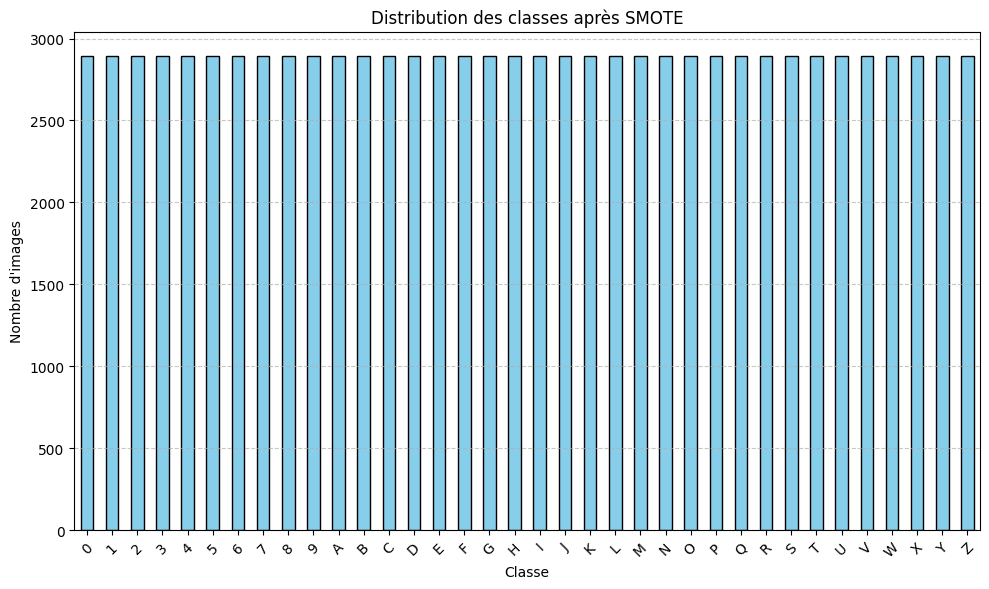

In [ ]:
# Visualisation de la distribution après SMOTE
label_counts = Counter(y_resampled)
label_series = pd.Series(label_counts).sort_index()

plt.figure(figsize=(10, 6))
label_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des classes après SMOTE")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Affichage d'exemples d'images par label :


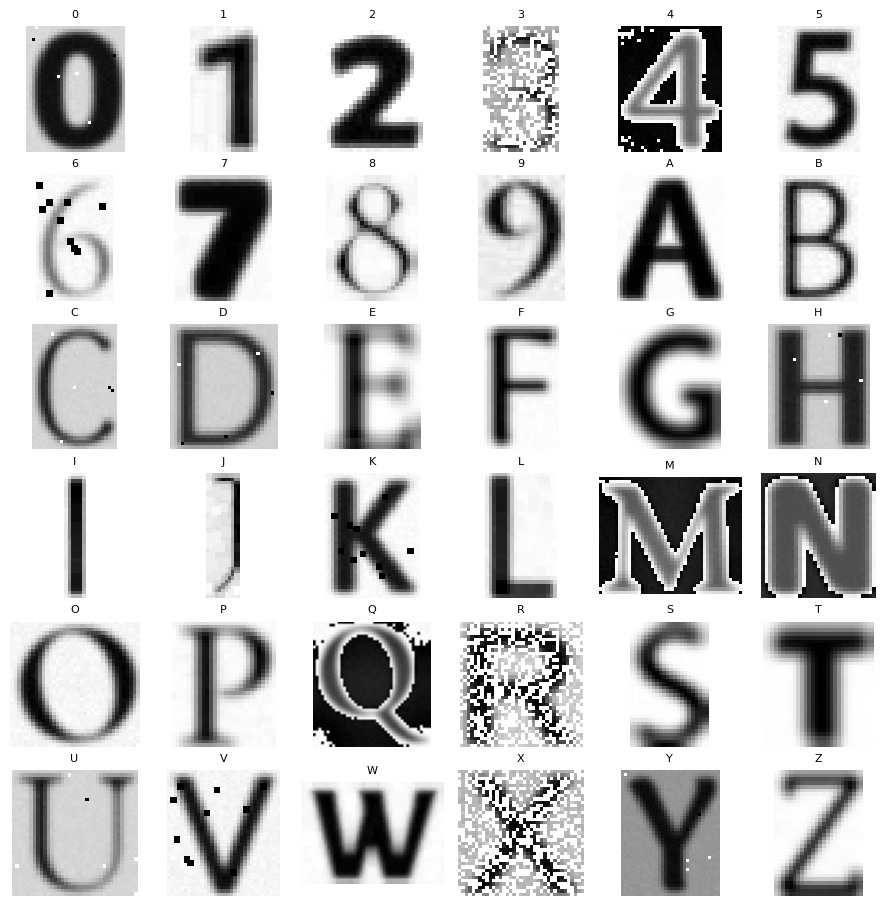

In [ ]:
NUM_EXAMPLES_PER_LABEL = 1

print("\nAffichage d'exemples d'images par label :")

label_folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])
num_labels = len(label_folders)

cols = int(np.ceil(np.sqrt(num_labels)))
rows = int(np.ceil(num_labels / cols))

# Taille de figure réduite
plt.figure(figsize=(cols * 1.5, rows * 1.5))

for i, label_folder in enumerate(label_folders):
    folder_path = os.path.join(base_dir, label_folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        selected_images = random.sample(image_files, min(NUM_EXAMPLES_PER_LABEL, len(image_files)))

        for filename in selected_images:
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                plt.subplot(rows, cols, i + 1)
                plt.imshow(img, cmap='gray')
                plt.title(label_folder, fontsize=8)  # Titre plus petit
                plt.axis('off')

plt.tight_layout(pad=0.5)  # Moins d'espacement
plt.show()


### Division du jeu de données équilibré après SMOTE

Après avoir appliqué **SMOTE** pour équilibrer les classes, nous procédons à la séparation du jeu de données en deux sous-ensembles :

- **80 % pour l'entraînement** (`X_train`, `y_train`)
- **20 % pour le test** (`X_test`, `y_test`)

La méthode `train_test_split` est utilisée avec l’option `stratify=y_resampled` afin de conserver une distribution équilibrée des classes dans les deux sous-ensembles.

Ensuite, les tableaux NumPy sont convertis en `DataFrame` (pour `X`) et en `Series` (pour `y`) pour une manipulation plus aisée avec **pandas**.

Enfin, chaque jeu (`X` et `y`) est concaténé en un seul `DataFrame` :
- `training_df` contient les exemples d’entraînement avec leurs étiquettes.
- `testing_df` contient les exemples de test.



In [ ]:
#  Étape 1 : Séparer les données équilibrées en ensembles d'entraînement et de test
# On utilise 80 % des données pour l'entraînement et 20 % pour le test
# L'argument stratify permet de conserver la même proportion de chaque classe dans les deux ensembles
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Affichage des dimensions des jeux de données
print(f"Forme de X_train : {X_train.shape}, Forme de y_train : {y_train.shape}")
print(f"Forme de X_test : {X_test.shape}, Forme de y_test : {y_test.shape}")

# Étape 2 : Conversion des tableaux NumPy en DataFrame (X) et Series (y)
X_train_df = pd.DataFrame(X_train)              # Données d'entraînement
y_train_series = pd.Series(y_train, name='label')  # Étiquettes d'entraînement

X_test_df = pd.DataFrame(X_test)                # Données de test
y_test_series = pd.Series(y_test, name='label')    # Étiquettes de test

Forme de X_train : (83404, 1024), Forme de y_train : (83404,)
Forme de X_test : (20852, 1024), Forme de y_test : (20852,)


In [ ]:
#  Étape 3 : Fusion des données X et des labels y pour constituer un seul DataFrame
# ignore_index=True permet de réinitialiser l'index pour éviter les duplications
training_df = pd.concat([X_train_df, y_train_series], axis=1, ignore_index=True)
testing_df = pd.concat([X_test_df, y_test_series], axis=1, ignore_index=True)

# Affichage d’un aperçu des deux DataFrames générés
print("\nCréation des DataFrames training_df et testing_df :")
print("Aperçu de training_df :")
training_df.head()


Création des DataFrames training_df et testing_df :
Aperçu de training_df :


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,178,178,178,171,157,140,135,131,131,131,...,65,65,64,64,64,65,74,98,98,Z
1,217,217,217,217,216,215,214,213,212,210,...,169,169,169,170,175,182,195,203,208,2
2,94,94,94,94,93,93,94,95,94,95,...,67,68,66,66,67,71,74,82,90,M
3,220,220,221,221,219,216,211,201,190,178,...,185,195,203,210,215,218,219,220,221,5
4,198,198,191,191,186,184,184,183,185,186,...,151,150,148,148,148,158,171,185,185,E



Nombre d'images par label dans l'ensemble d'entraînement (y_train) :


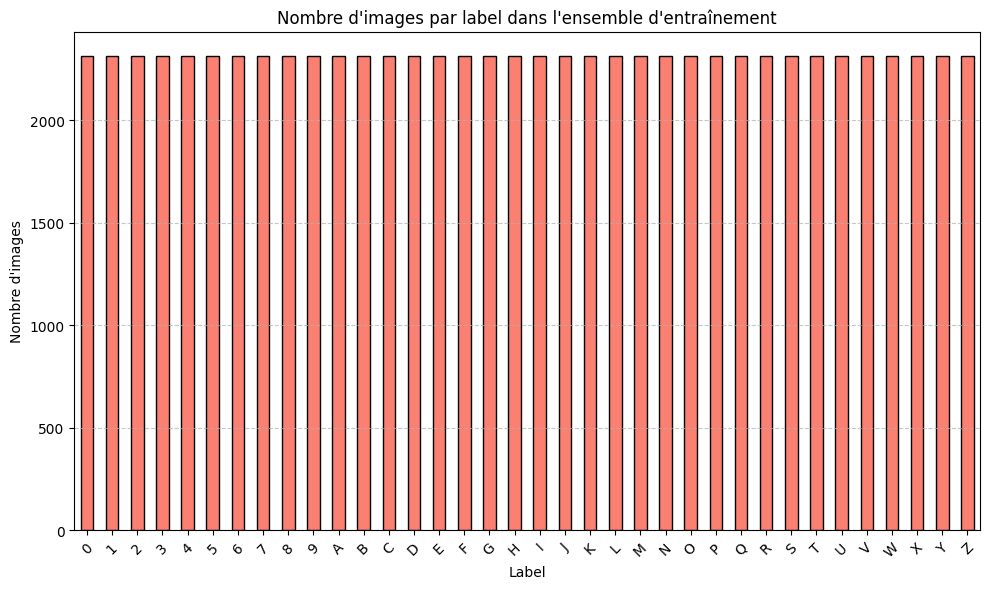

In [ ]:
# --- Visualisation du nombre de labels dans y_train ---
print("\nNombre d'images par label dans l'ensemble d'entraînement (y_train) :")

# Compter la distribution des labels dans y_train
train_label_counts = Counter(y_train)


# Convertir en pandas Series pour le graphique
train_label_series = pd.Series(train_label_counts)

# Sort the series by index (label) for consistent plotting
train_label_series = train_label_series.sort_index()

# 📈 Graphe en barres
plt.figure(figsize=(10, 6))
train_label_series.plot(kind='bar', color='salmon', edgecolor='black') # Utiliser une couleur différente
plt.title("Nombre d'images par label dans l'ensemble d'entraînement")
plt.xlabel("Label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## --- Étape 1 : Standardisation des données ---

In [ ]:
# On met à l'échelle les valeurs des pixels entre 0 et 1 pour faciliter l'entraînement du modèle
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(" Données standardisées.")

 Données standardisées.



## --- Étape 2 : Préparation des données pour le CNN ---

In [ ]:
# Reshape des données pour correspondre à l'entrée du CNN : (nombre d'exemples, hauteur, largeur, canaux)
# Ici, images en niveaux de gris, donc canaux = 1
img_height, img_width = TARGET_SIZE
X_train = X_train.reshape(-1, img_height, img_width, 1)
X_test = X_test.reshape(-1, img_height, img_width, 1)

print(f" Données reshaped pour CNN. Forme de X_train : {X_train.shape}, X_test : {X_test.shape}")

 Données reshaped pour CNN. Forme de X_train : (83404, 32, 32, 1), X_test : (20852, 32, 32, 1)


##Explication de l'encodage des labels en one-hot vectors

Dans une tâche de classification multi-classes, les labels (étiquettes) sont souvent des catégories sous forme de chaînes de caractères (par exemple : 'A', 'B', 'C', ou '0', '1', '2', etc.).

## Pourquoi encoder les labels ?

- Les modèles de deep learning travaillent mieux avec des valeurs numériques.
- Il faut convertir ces labels textuels en une représentation numérique compréhensible par le modèle.

## Étapes de l'encodage utilisé ici :

1. **LabelEncoder()**  
   - Transforme chaque label texte en un entier unique.  
   - Exemple : ['A', 'B', 'C', 'A'] → [0, 1, 2, 0]

2. **to_categorical()**  
   - Convertit ces entiers en vecteurs "one-hot", c’est-à-dire des vecteurs où la position correspondant à la classe est 1, et les autres positions sont 0.  
   - Exemple avec 3 classes :  
     - 0 → [1, 0, 0]  
     - 1 → [0, 1, 0]  
     - 2 → [0, 0, 1]

## Avantages du one-hot encoding :

- Permet au modèle de traiter chaque classe comme une catégorie distincte.
- Utilisé dans la couche de sortie avec activation softmax, qui prédit une probabilité pour chaque classe.

---

### Résumé

Le label encoder convertit les classes en entiers, puis la fonction `to_categorical` transforme ces entiers en vecteurs one-hot adaptés à la classification multi-classes dans les réseaux de neurones.


In [ ]:
# Encodage des labels en one-hot vectors pour la classification multi-classes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

print(f" Labels encodés en one-hot. Forme y_train_one_hot : {y_train_one_hot.shape}, y_test_one_hot : {y_test_one_hot.shape}")

 Labels encodés en one-hot. Forme y_train_one_hot : (83404, 36), y_test_one_hot : (20852, 36)


In [ ]:
y_train_encoded

## --- Étape 3 : Construction du modèle CNN avec transfert d'apprentissage (MobileNetV2) ---

**Explication : MobileNetV2 et les images en niveaux de gris**

MobileNetV2 est un modèle de **réseau de neurones convolutifs (CNN)** pré-entraîné sur le jeu de données ImageNet, qui contient des images en couleur (RGB) avec **3 canaux** (rouge, vert, bleu).

**Relation entre CNN et MobileNetV2**

- **CNN (Convolutional Neural Network)** est une architecture spécialisée pour traiter des images en capturant automatiquement les caractéristiques visuelles (bords, textures, formes, etc.) via des filtres convolutifs.
- MobileNetV2 est un **type spécifique de CNN optimisé** pour être léger et efficace, notamment sur des appareils mobiles. Il utilise des blocs convolutifs améliorés (bottleneck, depthwise separable convolutions) pour réduire la complexité tout en conservant de bonnes performances.

**Pourquoi convertir les images grayscale en 3 canaux ?**

- Les images en niveaux de gris ont **un seul canal** (intensité lumineuse).
- MobileNetV2, comme la plupart des CNN pré-entraînés sur ImageNet, attend une entrée avec **3 canaux** car il a appris à extraire des caractéristiques en exploitant les différences entre les canaux couleur.
- Pour utiliser MobileNetV2 avec des images grayscale, on **duplique** simplement la même image sur les 3 canaux. Cela permet de créer une image "factice" en 3 canaux, compatible avec le modèle, sans perdre l’information initiale.
  
Cette adaptation permet de profiter des puissantes caractéristiques apprises par MobileNetV2 même sur des images en niveaux de gris.

---

En résumé, MobileNetV2 est un CNN efficace conçu pour traiter des images couleur (3 canaux). Pour utiliser ce modèle avec des images grayscale, on adapte les données en dupliquant le canal unique pour correspondre à l'entrée attendue, ce qui facilite le transfert d'apprentissage et améliore la performance sur votre tâche.


In [ ]:
# MobileNetV2 attend une entrée avec 3 canaux (RGB), alors on convertit les images grayscale en 3 canaux en dupliquant
X_train_3_channels = np.repeat(X_train, 3, axis=-1)
X_test_3_channels = np.repeat(X_test, 3, axis=-1)

# Charger MobileNetV2 pré-entraîné, sans la tête de classification (include_top=False)
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Geler les couches de base pour ne pas entraîner MobileNetV2 entièrement
base_model.trainable = False

# Construction du modèle complet avec ajout de couches de pooling et dense pour classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Réduit la sortie de MobileNet en un vecteur moyen global
    Dense(128, activation='relu'),  # Couche fully connected avec activation ReLU
    Dropout(0.5),  # Régularisation pour éviter le surapprentissage
    Dense(len(label_encoder.classes_), activation='softmax')  # Couche de sortie avec activation softmax pour classification multi-classes
])

print(" Modèle CNN construit avec MobileNetV2.")


<ipython-input-27-661dcf4e0ec4>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
 Modèle CNN construit avec MobileNetV2.


# 2) Entraînement d'un modèle CNN avec MobileNetV2 et Keras Tuner

Les étapes de l'entraînement d'un modèle de classification d'images en utilisant un modèle pré-entraîné **MobileNetV2** et une recherche d'hyperparamètres via **Keras Tuner**:



1. **Recherche des meilleurs hyperparamètres** :
   - Taux d'apprentissage (`learning_rate`)
   - Nombre de neurones dans la couche dense (`dense_units`)
   - Taux de Dropout (`dropout_rate`)
   - Entraînement du modèle de base (`fine_tune`)

In [ ]:
# --- Modèle avec Keras Tuner ---
def build_model(hp):
    base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                             include_top=False, weights='imagenet')
    base_model.trainable = hp.Boolean('fine_tune', default=False)

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.7])))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('lr', [1e-4, 5e-4, 1e-3])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory='tuner_dir',
    project_name='mobilenetv2_opt'
)

tuner.search(X_train_3_channels, y_train_one_hot,
             epochs=5,
             batch_size=32,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# --- Extraire les résultats du tuner dans un DataFrame ---
results = tuner.results_summary(num_trials=100)  # Affiche dans la console
# Pour récupérer les résultats sous forme de DataFrame :
df = pd.DataFrame([
    {
        'dense_units': trial.hyperparameters.get('dense_units'),
        'dropout_rate': trial.hyperparameters.get('dropout_rate'),
        'lr': trial.hyperparameters.get('lr'),
        'fine_tune': trial.hyperparameters.get('fine_tune'),
        'val_accuracy': trial.score
    }
    for trial in tuner.oracle.get_best_trials(num_trials=100)
    if trial.status == 'COMPLETED'
])


Trial 2 Complete [00h 04m 26s]
val_accuracy: 0.9534800052642822

Best val_accuracy So Far: 0.9534800052642822
Total elapsed time: 00h 06m 32s
Results summary
Results in tuner_dir/mobilenetv2_opt
Showing 100 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
fine_tune: True
dense_units: 256
dropout_rate: 0.5
lr: 0.0005
Score: 0.9534800052642822

Trial 0 summary
Hyperparameters:
fine_tune: False
dense_units: 256
dropout_rate: 0.7
lr: 0.001
Score: 0.5600383877754211


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(" Meilleurs hyperparamètres trouvés :", best_hyperparameters.values)

<ipython-input-31-fc6dcde9e76e>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


 Meilleurs hyperparamètres trouvés : {'fine_tune': True, 'dense_units': 256, 'dropout_rate': 0.5, 'lr': 0.0005}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



2. **Construction du modèle final** :
   - Base : `MobileNetV2` sans la couche de classification
   - Ajout de : GlobalAveragePooling, Dense, Dropout, et une couche Softmax
   - Compilation avec `Adam` et `categorical_crossentropy`


In [ ]:
# --- Récupération des meilleurs hyperparamètres ---
best_hps = best_hyperparameters.values
fine_tune = best_hps['fine_tune']         # Faut-il entraîner ou non les couches du modèle pré-entraîné ?
dense_units = best_hps['dense_units']     # Nombre de neurones dans la couche Dense
dropout_rate = best_hps['dropout_rate']   # Taux de Dropout pour la régularisation
learning_rate = best_hps['lr']            # Taux d'apprentissage

print(f" Entraînement du modèle final avec les meilleurs hyperparamètres :")
print(f"  fine_tune: {fine_tune}")
print(f"  dense_units: {dense_units}")
print(f"  dropout_rate: {dropout_rate}")
print(f"  learning_rate: {learning_rate}")

# --- Construction du modèle final avec les meilleurs hyperparamètres ---
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False, weights='imagenet')  # Chargement du modèle MobileNetV2 sans la tête

# Définir si le modèle de base est entraînable ou non
base_model.trainable = fine_tune

# Création du modèle final (séquentiel)
final_model = Sequential([
    base_model,                                 # Modèle pré-entraîné comme extracteur de caractéristiques
    GlobalAveragePooling2D(),                   # Réduction de dimensions après les convolutions
    Dense(dense_units, activation='relu'),      # Couche Dense avec ReLU
    Dropout(dropout_rate),                      # Dropout pour éviter le surapprentissage
    Dense(len(label_encoder.classes_), activation='softmax')  # Couche de sortie (classification multi-classes)
])

# Compilation du modèle avec l'optimiseur Adam et le taux d'apprentissage choisi
final_model.compile(optimizer=Adam(learning_rate=learning_rate),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Modèle final construit et compilé.")

# --- Définition des callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,            # Arrêt si la performance ne s'améliore pas pendant 15 epochs
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'final_best_model.h5',  # Enregistrement du meilleur modèle
    save_best_only=True,
    monitor='val_loss'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,             # Réduction du taux d'apprentissage si stagnation
    patience=7,
    min_lr=0.0001
)

 Entraînement du modèle final avec les meilleurs hyperparamètres :
  fine_tune: True
  dense_units: 256
  dropout_rate: 0.5
  learning_rate: 0.0005


<ipython-input-37-2b0571a679ec>:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3),


Modèle final construit et compilé.


3. **Entraînement du modèle final** :
   - Utilisation de callbacks : `EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`
   - Validation croisée (20% des données pour la validation)

In [ ]:
# --- Entraînement du modèle final ---
print("\n Entraînement du modèle final...")
history_final = final_model.fit(
    X_train_3_channels, y_train_one_hot,
    epochs=10,              # Nombre d’époques fixé à 10 (peut être augmenté)
    batch_size=32,
    validation_split=0.2,   # 20 % des données utilisées pour la validation
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

print(" Entraînement du modèle final terminé.")


⏳ Entraînement du modèle final...
Epoch 1/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5774 - loss: 1.6240

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 95s 25ms/step - accuracy: 0.5775 - loss: 1.6236 - val_accuracy: 0.8534 - val_loss: 0.5066 - learning_rate: 5.0000e-04
Epoch 2/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8922 - loss: 0.3953

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.8922 - loss: 0.3952 - val_accuracy: 0.9344 - val_loss: 0.2440 - learning_rate: 5.0000e-04
Epoch 3/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9163 - loss: 0.3124 - val_accuracy: 0.9405 - val_loss: 0.3178 - learning_rate: 5.0000e-04
Epoch 4/10
2083/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9367 - loss: 0.2342

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.9367 - loss: 0.2341 - val_accuracy: 0.9478 - val_loss: 0.2081 - learning_rate: 5.0000e-04
Epoch 5/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9438 - loss: 0.2156

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 51s 20ms/step - accuracy: 0.9438 - loss: 0.2156 - val_accuracy: 0.9546 - val_loss: 0.1920 - learning_rate: 5.0000e-04
Epoch 6/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.9526 - loss: 0.1775 - val_accuracy: 0.9345 - val_loss: 0.2829 - learning_rate: 5.0000e-04
Epoch 7/10
2084/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9537 - loss: 0.1747

2086/2086 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9537 - loss: 0.1747 - val_accuracy: 0.9689 - val_loss: 0.1264 - learning_rate: 5.0000e-04
Epoch 8/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.9591 - loss: 0.1532 - val_accuracy: 0.9567 - val_loss: 0.1855 - learning_rate: 5.0000e-04
Epoch 9/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9589 - loss: 0.1501 - val_accuracy: 0.9609 - val_loss: 0.1510 - learning_rate: 5.0000e-04
Epoch 10/10
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9636 - loss: 0.1316 - val_accuracy: 0.9606 - val_loss: 0.1504 - learning_rate: 5.0000e-04
✅ Entraînement du modèle final terminé.


#3)Évaluation du modèle final

4. **Sauvegarde et évaluation** :
   - Le meilleur modèle est sauvegardé automatiquement
   - Possibilité d'évaluer sur les données de test par la suite

---

In [ ]:
# --- Évaluation du modèle final ---
print("\n Évaluation du modèle final...")
loss_final, accuracy_final = final_model.evaluate(X_test_3_channels, y_test_one_hot)
print(f" Perte du Test final : {loss_final:.4f}")
print(f" Précision du Test final : {accuracy_final:.4f}")


 Évaluation du modèle final...
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9673 - loss: 0.1168
 Perte du Test final : 0.1291
 Précision du Test final : 0.9665


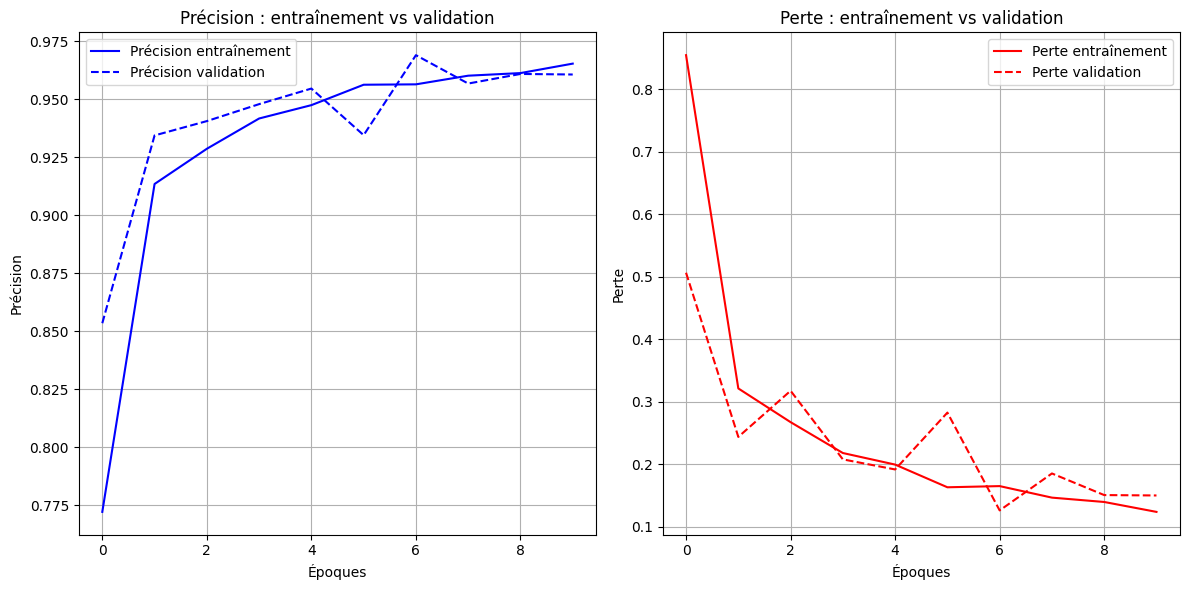

In [ ]:
# Récupération des précisions d'entraînement et de validation
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']

# Récupération des pertes d'entraînement et de validation
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

# Création de la plage des époques (x-axis)
epochs = range(len(acc))

# --- Affichage des courbes d'entraînement et de validation ---
plt.figure(figsize=(12, 6))

# Sous-graphique 1 : Précision (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Précision entraînement')       # Ligne bleue continue
plt.plot(epochs, val_acc, 'b--', label='Précision validation')     # Ligne bleue pointillée
plt.title('Précision : entraînement vs validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Sous-graphique 2 : Perte (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Perte entraînement')           # Ligne rouge continue
plt.plot(epochs, val_loss, 'r--', label='Perte validation')        # Ligne rouge pointillée
plt.title('Perte : entraînement vs validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Ajustement automatique de la mise en page
plt.tight_layout()
plt.show()


**Analyse Résumée des Courbes d’Entraînement**

Les courbes de précision et de perte montrent que le modèle OCR apprend efficacement sans tomber dans l’**overfitting**.

-  **Précision** : Les courbes d’entraînement et de validation sont proches et augmentent régulièrement, ce qui indique un bon apprentissage et une bonne généralisation.
-  **Perte** : Les pertes diminuent pour les deux ensembles avec une légère instabilité côté validation, due aux données bruitées. Elles restent cependant proches.

Le modèle est **robuste** et **généralise bien**. L’**augmentation de données** a permis d’améliorer sa résistance aux défauts des images à faible résolution, sans nuire aux performances.


In [ ]:
from sklearn.metrics import confusion_matrix

# --- Générer les prédictions sur l'ensemble de test ---
print("\n Génération des prédictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Conversion des prédictions et des vraies étiquettes de one-hot vers indices de classes
y_pred_classes = np.argmax(y_pred_one_hot, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

print(" Prédictions générées.")

# --- Calcul de la matrice de confusion ---
# On suppose que le label_encoder est déjà entraîné sur l'ensemble des étiquettes
class_names = label_encoder.classes_

cm = confusion_matrix(y_true_classes, y_pred_classes)



 Génération des prédictions sur l'ensemble de test...
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
 Prédictions générées.


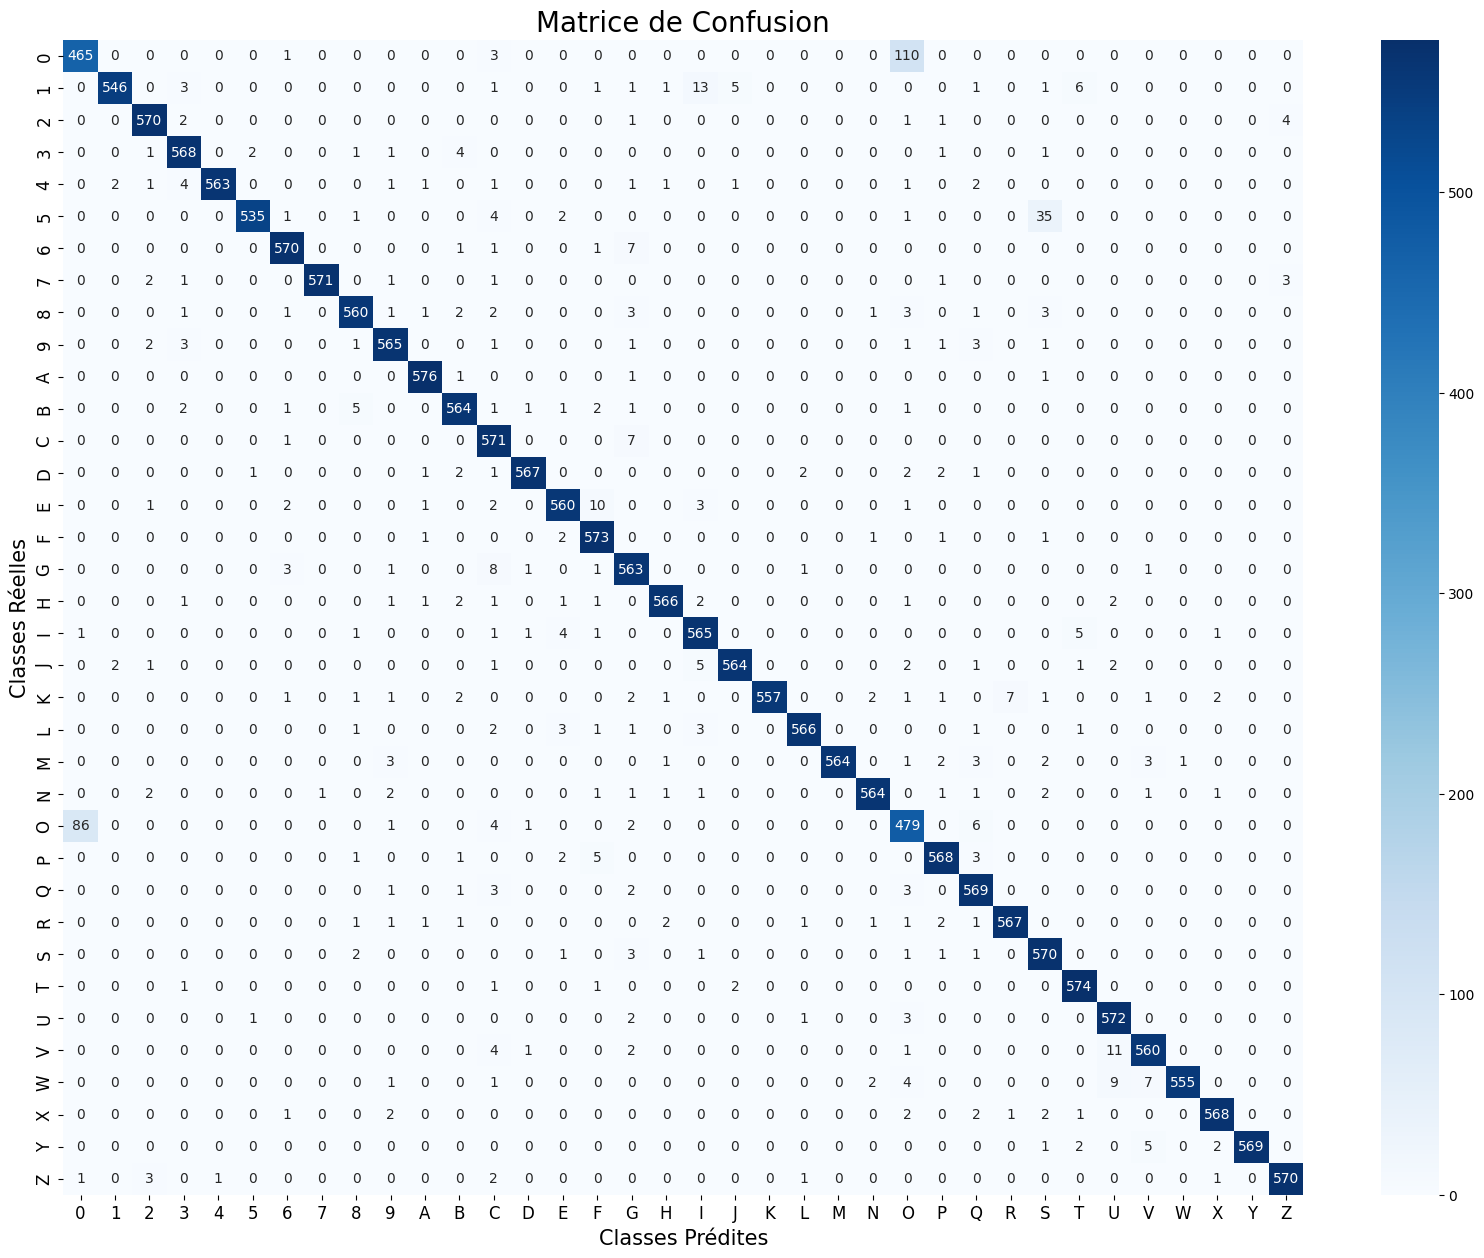


 Matrice de confusion affichée.


In [ ]:
# --- Affichage de la matrice de confusion ---
# Création d'une figure plus grande pour améliorer la lisibilité du graphique
plt.figure(figsize=(20, 15))  # Largeur : 20, Hauteur : 15

# Affichage de la matrice avec des couleurs et les annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Personnalisation du graphique : titre et labels des axes
plt.title('Matrice de Confusion', fontsize=20)           # Titre en plus grand
plt.xlabel('Classes Prédites', fontsize=15)              # Axe des X : classes prédites
plt.ylabel('Classes Réelles', fontsize=15)               # Axe des Y : classes réelles
plt.xticks(fontsize=12)                                  # Taille de police pour les étiquettes X
plt.yticks(fontsize=12)                                  # Taille de police pour les étiquettes Y

# Affichage final du graphique
plt.show()

print("\n Matrice de confusion affichée.")

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# --- Génération du rapport de classification de sklearn ---
report = classification_report(y_true_classes, y_pred_classes,
                               target_names=class_names, output_dict=True)

# --- Calcul manuel des métriques supplémentaires (spécificité, erreur) ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
metrics = []

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensibilité
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    error = (FP + FN) / (TP + FN + FP + TN)

    metrics.append({
        "Classe": class_name,
        "Précision": round(precision, 3),
        "Rappel (Recall)": round(recall, 3),
        "Spécificité": round(specificity, 3),
        "F1-score": round(f1, 3),
        "Taux d'erreur": round(error, 3)
    })

# --- Création du tableau final ---
df_metrics = pd.DataFrame(metrics)

# --- Affichage du tableau ---
print("📋 Tableau des métriques par classe :\n")
display(df_metrics)

# --- Accuracy globale ---
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\n Exactitude (accuracy) globale : {round(accuracy, 4)}")


📋 Tableau des métriques par classe :



,Classe,Précision,Rappel (Recall),Spécificité,F1-score,Taux d'erreur
0,0,0.841,0.803,0.996,0.822,0.010
1,1,0.993,0.943,1.000,0.967,0.002
2,2,0.978,0.984,0.999,0.981,0.001
3,3,0.969,0.981,0.999,0.975,0.001
4,4,0.998,0.972,1.000,0.985,0.001
5,5,0.993,0.924,1.000,0.957,0.002
6,6,0.979,0.983,0.999,0.981,0.001
7,7,0.998,0.984,1.000,0.991,0.000
8,8,0.974,0.967,0.999,0.971,0.002
9,9,0.969,0.976,0.999,0.972,0.002



 Exactitude (accuracy) globale : 0.9665


In [ ]:
def extract(image, model, mapping_inverse):
    chars = []
    image_cpy = image.copy()

    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)

    for word in words:
        x, y, w, h = word
        img = image_cpy[y:y+h, x:x+w]

        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)

        for char in char_parts:
            x, y, w, h = char
            ch = img[y:y+h, x:x+w]

            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)
            resized = cv2.resize(ch, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3+22, 3:3+16, 0] = gray.copy()

            rgb_img = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            rgb_img = rgb_img.astype(np.int32)

            pred = model.predict(np.array([rgb_img]), verbose=0)
            predicted_char = mapping_inverse[np.argmax(pred)]
            chars.append(predicted_char)

        chars.append(' ')  # espace entre mots

    return ''.join(chars[:-1])  # retirer le dernier espace


In [ ]:
# --- Prédictions sur l'ensemble de test ---
print("\n* Génération des prédictions sur l'ensemble de test...")
y_pred_one_hot = final_model.predict(X_test_3_channels)

# Conversion des prédictions et labels one-hot en indices de classes
y_pred_indices = np.argmax(y_pred_one_hot, axis=1)
y_true_indices = np.argmax(y_test_one_hot, axis=1)

# Récupération des labels originaux via le label encoder
y_pred_labels = label_encoder.classes_[y_pred_indices]
y_true_labels = label_encoder.classes_[y_true_indices]

print("Prédictions converties en labels.")

# Création du DataFrame avec labels vrais, prédits et indicateur de bonne classification
results_df = pd.DataFrame({
    'Vrai_Label': y_true_labels,
    'Prédit_Label': y_pred_labels,
    'Correct': y_true_labels == y_pred_labels
})

print("\nAperçu des résultats :")
results_df.head()


* Génération des prédictions sur l'ensemble de test...
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Prédictions converties en labels.

Aperçu des résultats :


,Vrai_Label,Prédit_Label,Correct
0,L,L,True
1,B,B,True
2,G,G,True
3,0,0,True
4,F,E,False


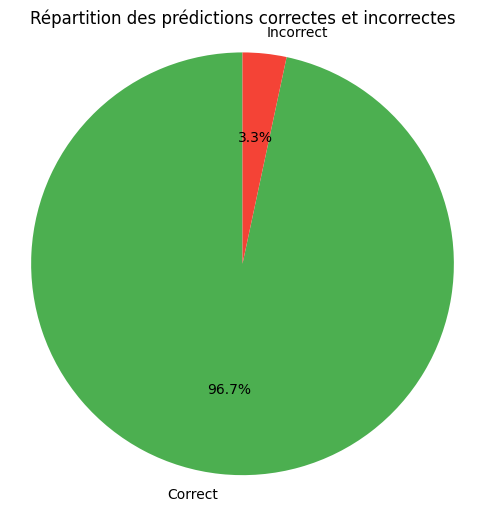

In [ ]:
# Comptage des bonnes et mauvaises prédictions
counts = results_df['Correct'].value_counts()
labels = ['Correct' if x else 'Incorrect' for x in counts.index]
sizes = counts.values

# Tracé du camembert
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#F44336'], startangle=90)
plt.title("Répartition des prédictions correctes et incorrectes")
plt.axis('equal')  # Assure que le graphique est circulaire
plt.show()


**Analyse de la répartition des prédictions**

Le diagramme circulaire ci-dessus illustre la performance globale du modèle en termes de prédictions correctes et incorrectes :

-  **Prédictions correctes** : **96.7 %**
-  **Prédictions incorrectes** : **3.3 %**

Cela indique que le modèle est globalement très précis, avec une excellente capacité de généralisation.  
Le faible taux d’erreur (**3.3 %**) confirme l’efficacité du modèle sur les données de test.


#4)Sauvegarde du modèle entraîné & Génération des prédictions

In [ ]:
# --- Sauvegarde du modèle entraîné ---

# Définition du chemin où enregistrer le modèle
model_save_path = 'final_trained_model.h5'

print(f" Sauvegarde du modèle entraîné vers {model_save_path}...")

# Sauvegarde complète du modèle : architecture, poids et état de l'optimiseur
final_model.save(model_save_path)

print(" Modèle sauvegardé avec succès.")

# Vérification optionnelle que le fichier a bien été créé
import os
if os.path.exists(model_save_path):
    print(f"Le fichier modèle '{model_save_path}' a bien été créé.")
else:
    print(f"Erreur lors de la sauvegarde du fichier modèle '{model_save_path}'.")

 Sauvegarde du modèle entraîné vers final_trained_model.h5...
 Modèle sauvegardé avec succès.
Le fichier modèle 'final_trained_model.h5' a bien été créé.


In [ ]:
import os

# Define the path for the new directory
new_directory_path = 'data_rgb'

# Create the directory
try:
    os.makedirs(new_directory_path)
    print(f"✅ Dossier '{new_directory_path}' créé avec succès.")
except FileExistsError:
    print(f"Le dossier '{new_directory_path}' existe déjà.")
except Exception as e:
    print(f"Une erreur s'est produite lors de la création du dossier : {e}")

Le dossier 'data_rgb' existe déjà.


In [ ]:
import os

# Définir le chemin du dossier
directory_path = '/content/data_test'

# Créer le dossier s'il n'existe pas déjà
os.makedirs(directory_path, exist_ok=True)

print(f"Le dossier '{directory_path}' a été créé avec succès (ou existe déjà).")


Le dossier '/content/data_test' a été créé avec succès (ou existe déjà).


Dossier '/content/data_test' trouvé.
6 fichiers image trouvés dans le dossier.

Génération des prédictions pour chaque image...
Image: images.jpeg, Prédiction: O


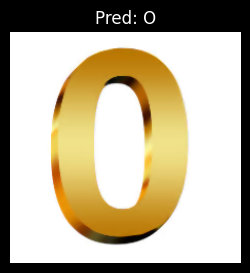

Image: imageE.png, Prédiction: E


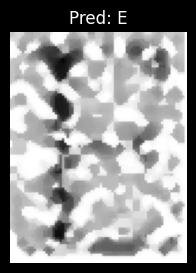

Image: 61Gnse56wAL._AC_UF1000,1000_QL80_.jpg, Prédiction: B


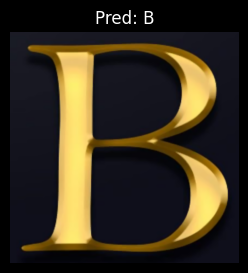

Image: copy-of-chiffre-0.jpg, Prédiction: 1


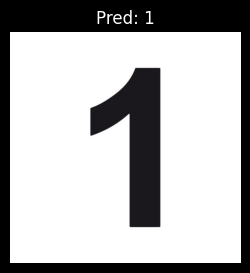

Image: E.png, Prédiction: E


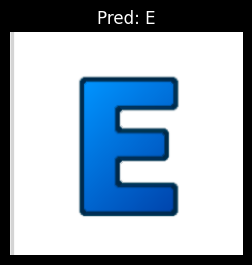

Image: image1.jpeg, Prédiction: D


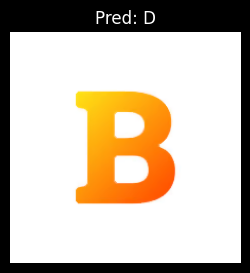


✅ Prédictions terminées pour toutes les images.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Paramètres
test_directory_path = "/content/data_test"
TARGET_SIZE = (32, 32)  # Nouvelle taille
ZOOM_MARGIN = 20  # Marge autour de l'objet détecté

# Vérifie l'existence du dossier
if not os.path.isdir(test_directory_path):
    print(f"Erreur: Le dossier '{test_directory_path}' n'existe pas.")
else:
    print(f"Dossier '{test_directory_path}' trouvé.")

    image_files = [f for f in os.listdir(test_directory_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"Aucun fichier image trouvé dans le dossier '{test_directory_path}'.")
    else:
        print(f"{len(image_files)} fichiers image trouvés dans le dossier.")
        print("\nGénération des prédictions pour chaque image...")

        for filename in image_files:
            image_path = os.path.join(test_directory_path, filename)
            image_to_test = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if image_to_test is None:
                print(f"Erreur: Impossible de charger l'image '{filename}'. Skipping.")
                continue

            # Appliquer un filtre médian (réduction du bruit)
            image_filtered = cv2.medianBlur(image_to_test, 5)

            # Convertir en niveaux de gris
            img_gray = cv2.cvtColor(image_filtered, cv2.COLOR_BGR2GRAY)

            # --- Zoom sur l'objet (bounding box de contours) ---
            thresh = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY)[1]
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Boîte englobante la plus grande
                x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                x1 = max(x - ZOOM_MARGIN, 0)
                y1 = max(y - ZOOM_MARGIN, 0)
                x2 = min(x + w + ZOOM_MARGIN, image_to_test.shape[1])
                y2 = min(y + h + ZOOM_MARGIN, image_to_test.shape[0])
                image_zoomed = image_filtered[y1:y2, x1:x2]
            else:
                image_zoomed = image_filtered  # Aucun contour trouvé

            # Redimensionner à 32x32
            img_resized = cv2.resize(cv2.cvtColor(image_zoomed, cv2.COLOR_BGR2GRAY), TARGET_SIZE)

            # Normaliser et préparer l'entrée du modèle
            img_normalized = img_resized.astype('float32') / 255.0
            img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
            img_input_model = np.repeat(img_reshaped, 3, axis=-1)

            # Prédiction
            prediction_probabilities = final_model.predict(img_input_model, verbose=0)
            predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
            predicted_label = label_encoder.classes_[predicted_class_index]

            # Affichage
            print(f"Image: {filename}, Prédiction: {predicted_label}")
            plt.figure(figsize=(3, 3))
            plt.imshow(cv2.cvtColor(image_zoomed, cv2.COLOR_BGR2RGB))
            plt.title(f"Pred: {predicted_label}")
            plt.axis('off')
            plt.show()

        print("\n✅ Prédictions terminées pour toutes les images.")


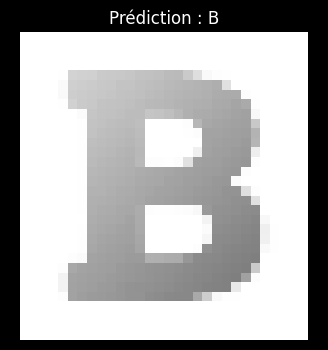

In [ ]:
    # 8. Redimensionnement final
    image_final = cv2.resize(image_gray, TARGET_SIZE)

    # 9. Normalisation et préparation pour modèle
    img_normalized = image_final.astype('float32') / 255.0
    img_reshaped = img_normalized.reshape(1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
    img_input_model = np.repeat(img_reshaped, 3, axis=-1)

    # Prédiction
    prediction_probabilities = final_model.predict(img_input_model, verbose=0)
    predicted_class_index = np.argmax(prediction_probabilities, axis=1)[0]
    predicted_label = label_encoder.classes_[predicted_class_index]

    # Affichage
    plt.figure(figsize=(4, 4))
    plt.imshow(image_final, cmap='gray')
    plt.title(f"Prédiction : {predicted_label}")
    plt.axis('off')
    plt.show()
